In [1]:
from __future__ import print_function

import os
import numpy as np
# import torch
# import pandas as pd
from io import StringIO
# from google.cloud import storage
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten
from keras.layers.core import Dense, Dropout, Activation, Layer, Lambda, Flatten
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam
from keras.layers.advanced_activations import LeakyReLU
import random
seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)

%matplotlib inline
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

Using TensorFlow backend.


# Load data from numpy arrays

In [2]:
def load_data_file(data_file, num_features):
    
    data = np.load(data_file)
    
    if data.ndim == 1:
        data = data[None, :]
    
    x = data[:, :num_features]
    y = data[:, num_features:]
    
    return x, y

In [87]:
num_features = 13
x_data, y_data = load_data_file(data_file='../../train/training_hela.npy', num_features=num_features)

In [88]:
Ntr = 70000
x_data_tr = x_data[:Ntr,:]
y_data_tr = y_data[:Ntr,:]
x_data_val = x_data[Ntr:,:]
y_data_val_un = y_data[Ntr:,:]

In [5]:
x_data.shape

(79999, 13)

# Training / Validation split

* Consider taking log 10 of data (Being careful not to take the log of the temperature features if they are included)

In [6]:
y_data.shape

(79999, 5)

In [7]:
# x_range = x_data.max(0) - x_data.min(0)
# y_range = y_data.max(0) - y_data.min(0)

## Normalise: remove mean and divide by standard deviation

In [89]:
# Normalise
x_data_tr = (x_data_tr - x_data.mean(0))/x_data.std(0)
x_data_val = (x_data_val - x_data.mean(0))/x_data.std(0)
# x_data_te = (x_data_te - x_data.mean(0))/x_data.std(0)

y_data_tr = (y_data_tr - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
y_data_val = (y_data_val_un - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
# y_data_te = (y_data_te - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]


# x_data_tr = (x_data_tr - x_data.min(0)) / ( x_range)
# x_data_val = (x_data_val - x_data.min(0)) / (x_range)

# y_data_tr = (y_data_tr - y_data.min(0)) / ( y_range)
# y_data_val = (y_data_val - y_data.min(0)) / (y_range)

In [9]:
x_data_tr = np.squeeze(x_data_tr)
x_data_val = np.squeeze(x_data_val)
# x_data_te = np.squeeze(x_data_te)

## For a CNN you need to add a channel at the end which is done in the cell below.
* If you want to use a FF NN, use the above cell and dont run the one below

In [10]:
# # CNN
# x_data_tr = np.expand_dims(x_data_tr,2)
# x_data_val = np.expand_dims(x_data_val,2)
# # x_data_te = np.expand_dims(x_data_val,2)

In [11]:
x_data_val.shape

(9999, 13)

In [12]:
y_data_val.shape

(9999, 5)

In [30]:
Early_Stop_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
# units
units = 1024
batch_size = 256
epochs = 64
dropout = 0.2
# Regularise
tau = 0.01
lengthscale = .01
reg = lengthscale**2 * (1 - dropout) / (2. * Ntr * tau)

# nb_filter = 64
# filter_length = 5
def network():
    model = Sequential()
#     model.add(Convolution1D(nb_filter=64, kernel_size=3, activation='tanh', input_shape=(x_data.shape[1], 1)))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Convolution1D(nb_filter=64, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     #model.add(Convolution1D(nb_filter=64, kernel_size=3, activation='elu'))
#     #model.add(MaxPooling1D(pool_size=2))
    
#     model.add(Convolution1D(nb_filter=128, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Convolution1D(nb_filter=256, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))

    
# #     model.add(Convolution1D(nb_filter=512, kernel_size=2, activation='relu'))
# #     model.add(MaxPooling1D(pool_size=2))
# #     model.add(Convolution1D(nb_filter=512, kernel_size=2, activation='relu'))
# #     model.add(MaxPooling1D(pool_size=2))
    
#     model.add(Flatten())
# #     model.add(Dense(512, activation='relu'))
# #     model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu'))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu'))
              #     model.add(Dense(units, activation='relu', input_shape=x_data_tr.shape[1:],W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
#     model.add(Dense(y_data_tr.shape[-1], activation='relu',W_regularizer=l2(reg)))
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(y_data_tr.shape[-1], activation='linear',W_regularizer=l2(reg)))
    return model

In [31]:
reg

5.714285714285715e-08

## Setting up the random seed

In [32]:
np.random.seed(seed=seed)
random.seed(seed)

N_ensemble = 1  #Number of networks in ensemble (I suggest sticking with 1)

## Training

In [33]:
nn_ensemble = []
training = True
weights_file_std = '../../model/cnn1_HELA.h5'   # Path to model weights
if training:
    for nn in range(N_ensemble):
        np.random.seed(seed=nn)
        random.seed(nn)
        # model_checkpoint: saves depending on validation
        model_checkpoint =  keras.callbacks.ModelCheckpoint(weights_file_std, monitor='val_loss', save_best_only=True,
                                           save_weights_only=True, mode='auto',verbose=0)

        std_model = network()
        std_model.compile(loss='mean_squared_error',
                          optimizer='adam')

        history_std = std_model.fit(x_data_tr, y_data_tr,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=[x_data_val,y_data_val],
                          callbacks=[model_checkpoint])
        std_model.load_weights(weights_file_std)  # Load model with best validation loss
        nn_ensemble.append(std_model)
        print(nn, ' COMPLETED')
else:
    if N_ensemble > 1:
        print('Loading models not currently working for ensemble')
    std_model = network()
    std_model.compile(loss='mean_squared_error',
                          optimizer='adam')
    std_model.load_weights(weights_file_std)
    nn_ensemble.append(std_model)

/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_regularizer=<keras.reg...)`
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_regularizer=<keras.reg...)`
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, activation="relu", kernel_regularizer=<keras.reg...)`
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="linear", kernel_regularizer=<keras.reg...)`


Train on 70000 samples, validate on 9999 samples
Epoch 1/64
70000/70000 [==============================] - 2s 34us/step - loss: 0.4242 - val_loss: 0.3571
Epoch 2/64
70000/70000 [==============================] - 2s 25us/step - loss: 0.3588 - val_loss: 0.3457
Epoch 3/64
70000/70000 [==============================] - 2s 25us/step - loss: 0.3524 - val_loss: 0.3493
Epoch 4/64
70000/70000 [==============================] - 2s 24us/step - loss: 0.3510 - val_loss: 0.3450
Epoch 5/64
70000/70000 [==============================] - 2s 25us/step - loss: 0.3472 - val_loss: 0.3498
Epoch 6/64
70000/70000 [==============================] - 2s 26us/step - loss: 0.3474 - val_loss: 0.3492
Epoch 7/64
70000/70000 [==============================] - 2s 24us/step - loss: 0.3455 - val_loss: 0.3423
Epoch 8/64
70000/70000 [==============================] - 2s 25us/step - loss: 0.3445 - val_loss: 0.3474
Epoch 9/64
70000/70000 [==============================] - 2s 24us/step - loss: 0.3441 - val_loss: 0.3428
Epoch 

In [34]:
std_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1024)              14336     
_________________________________________________________________
lambda_11 (Lambda)           (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
lambda_12 (Lambda)           (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
lambda_13 (Lambda)           (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              1049600   
__________

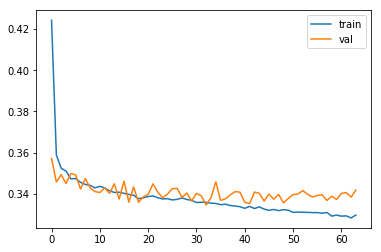

In [35]:
plt.plot(history_std.history['loss'],label='train')
plt.plot(history_std.history['val_loss'],label='val')
plt.legend()
# plt.savefig('../figures/valid/loss_CNN_Frank_network.pdf')
plt.show()

### RMSE for different combos (grid search :( )

In [ ]:
# RF results: RMSE
# # [351.99744748   2.32939053   2.73851797   2.16731624   2.21924031]

In [26]:
# ___units = 1024
# batch_size = 128
# epochs = 64
# dropout = 0.08
# # Regularise
# tau = 10000
# lengthscale = .01______________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# dense_7 (Dense)              (None, 1024)              14336     
# _________________________________________________________________
# lambda_6 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_8 (Dense)              (None, 1024)              1049600   
# _________________________________________________________________
# lambda_7 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_9 (Dense)              (None, 1024)              1049600   
# _________________________________________________________________
# lambda_8 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_10 (Dense)             (None, 1024)              1049600   
# _________________________________________________________________
# lambda_9 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_11 (Dense)             (None, 1024)              1049600   
# _________________________________________________________________
# lambda_10 (Lambda)           (None, 1024)              0         
# _________________________________________________________________
# dense_12 (Dense)             (None, 5)                 5125      
# =================================================================
# Total params: 4,217,861
# Trainable params: 4,217,861
# Non-trainable params: 0

# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [340.07877266   2.27595176   2.65851527   2.10068828   2.15610861]

(9999, 5)
[340.07877266   2.27595176   2.65851527   2.10068828   2.15610861]


In [36]:
# units = 1024
# batch_size = 256
# epochs = 64
# dropout = 0.2
# # Regularise
# tau = 0.01
# lengthscale = .01______________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# dense_7 (Dense)              (None, 1024)              14336     
# _________________________________________________________________
# lambda_6 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_8 (Dense)              (None, 1024)              1049600   
# _________________________________________________________________
# lambda_7 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_9 (Dense)              (None, 1024)              1049600   
# _________________________________________________________________
# lambda_8 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_10 (Dense)             (None, 1024)              1049600   
# _________________________________________________________________
# lambda_9 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_11 (Dense)             (None, 1024)              1049600   
# _________________________________________________________________
# lambda_10 (Lambda)           (None, 1024)              0         
# _________________________________________________________________
# dense_12 (Dense)             (None, 5)                 5125      
# =================================================================
# Total params: 4,217,861
# Trainable params: 4,217,861
# Non-trainable params: 0

preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
preds_denorm = preds * y_data.std(0) + y_data.mean(0)
y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
print(preds_denorm.shape)
rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
print(rmse)
# (9999, 5)
# [336.68266984   2.2697777    2.66103036   2.07316571   2.14066443]

(9999, 5)
[336.68266984   2.2697777    2.66103036   2.07316571   2.14066443]


In [28]:
# # test denorm error for mean norm (2 * tanh)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# # (9999, 5)
# # [348.33966495   2.28236494   2.71438089   2.16008919   2.17986165]

In [22]:
# # test denorm error for mean norm (4 * relu, 1024 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [335.42021214   2.25643578   2.66284313   2.10965753   2.14305779]

In [23]:
# # test denorm error for mean norm (4 * relu, 2048 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [337.87892212   2.29054677   2.65926488   2.0926183    2.15020789]

In [25]:
# # test denorm error for mean norm (4 * relu, units 3,2,1)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [335.37262741   2.27267598   2.65470067   2.0803818    2.15800546]

In [26]:
# # test denorm error for mean norm (4 * relu, 2048 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [344.86893266   2.27918209   2.67477766   2.19067704   2.18239063]

In [27]:
# # # test denorm error for mean norm (2 * tanh, 1024 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [342.9679369    2.27894085   2.68276775   2.14159416   2.18107573]

In [ ]:
# # test denorm error for mean norm (2 * tanh, 1024 units)
preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
preds_denorm = preds * y_data.std(0)[:5] + y_data.mean(0)[:5]
y_data_val_denorm = y_data_val * y_data.std(0)[:5] + y_data.mean(0)[:5]
print(preds_denorm.shape)
rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
print(rmse)

In [35]:
# # test denorm error for mean norm (2 * tanh, 1024 units)
preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
preds_denorm = preds * y_data.std(0)[:5] + y_data.mean(0)[:5]
y_data_val_denorm = y_data_val * y_data.std(0)[:5] + y_data.mean(0)[:5]
print(preds_denorm.shape)
rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
print(rmse)

(500, 5)
[0.02019119 0.11775095 0.09987461 0.1489149  0.01679041]


In [35]:
# # test denorm error for mean norm (1 epoch)
preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
preds_denorm = preds * y_data.std(0)[:5] + y_data.mean(0)[:5]
y_data_val_denorm = y_data_val * y_data.std(0)[:5] + y_data.mean(0)[:5]
print(preds_denorm.shape)
rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
print(rmse)

(10000, 5)
[0.02522289 0.15797298 0.15244118 0.15991646 0.02513462]


### Validation

In [186]:
# x_data_test, y_data_test = x_data_val, y_data_val #load_data_file(data_file='../test/testing_hela.npy', num_features=num_features)

In [187]:
x_data_val.std(0)

array([[0.99554288],
       [0.99551381],
       [0.99547506],
       ...,
       [0.96403652],
       [0.96434096],
       [0.96440715]])

In [188]:
x_data_te.std(0)

array([[[0.99554288]],

       [[0.99551381]],

       [[0.99547506]],

       ...,

       [[0.96403652]],

       [[0.96434096]],

       [[0.96440715]]])

In [189]:
x_data_tr.std(0)

array([[1.00095372],
       [1.00095527],
       [1.00095683],
       ...,
       [1.00517268],
       [1.0051277 ],
       [1.0051223 ]])

## Generate samples for validation data
* For each planet sample TxN_ensemble abundances

In [25]:
x_data_val[planet,:].shape

(13,)

In [32]:
y_data_tr.shape

(70000, 5)

In [27]:
std_model.predict(x_data_val[planet,:].reshape((1,-1)))

array([[ 1.6585102 , -0.93396735,  1.5108947 , -0.87242216,  0.80247736]],
      dtype=float32)

In [74]:
No_pred = y_data_val.shape[0] # Number of planets to predict over
T=50 # Number of samples from the network per planet (e.g. 100 different H2O predictions to give a heat map)
PRED = np.zeros((No_pred,N_ensemble,T,y_data_val.shape[-1]))
n = 0
for std_model in nn_ensemble:
    for planet in range(No_pred):
        PRED[planet,n] = np.array([std_model.predict(x_data_val[planet,:].reshape((1,-1))) for _ in range(T)]).squeeze()
        #PRED[planet,n] = np.array([std_model.predict(x_data_te[-1+planet,:].reshape((1,-1,1))).reshape((1,num_features)) for _ in range(T)]).squeeze() #earth?
        
        if planet % 1000 == 0:
            print(planet,' planet completed')
    # predictions_test = pipeline.trees_predict(np.array(x_data_test)[0,:])
    print(n,' models completed')
    n += 1

0  planet completed
1000  planet completed
2000  planet completed
3000  planet completed
4000  planet completed
5000  planet completed
6000  planet completed
7000  planet completed
8000  planet completed
9000  planet completed
0  models completed


In [75]:
PRED_o = PRED[:]

In [76]:
PRED = PRED_o[:,:n].reshape((No_pred,-1,y_data_val.shape[-1]))

# Plots: predictions vs true for validation
* Red line is the y = x just to show if there is correlation

In [77]:
np.dot(PRED,y_data_tr.std(0)[:num_features]).shape

(9999, 50)

In [78]:
y_data_tr.std(0)[:num_features].shape

(5,)

In [79]:
y_data_val

array([[ 1.56822958, -1.18232376,  1.31875397, -0.67543539,  0.54333166],
       [ 0.08094951,  0.31979857,  0.10866819, -0.67543539, -0.02365898],
       [ 0.4801466 ,  0.65263829,  0.80726212, -0.67543539,  1.16304124],
       ...,
       [ 1.02035099,  0.36405359, -0.59168984, -0.67543539,  0.37398541],
       [-0.67084713,  0.91245801,  0.90239904,  0.45491813,  1.5321652 ],
       [ 1.19384941,  1.62416694, -1.24302418, -0.67543539,  0.06274259]])

In [80]:
PRED*y_data_tr.std(0)[:num_features] + y_data_tr.mean(0)[:num_features]

array([[[ 1.54822666, -0.69814899,  1.29204102, -0.71599698,
          0.53343863],
        [ 1.41931266, -0.48780499,  1.27831587, -0.66563397,
          0.73379865],
        [ 1.78703305, -0.7403495 ,  1.53019664, -0.79724049,
          0.61709731],
        ...,
        [ 1.56193811, -0.58076582,  1.30481624, -0.71579575,
          0.49936737],
        [ 1.45563853, -0.50999364,  1.5382785 , -0.74762061,
          0.68303936],
        [ 1.57119577, -0.56021855,  1.48628729, -0.73534845,
          0.70686538]],

       [[ 0.26223701,  0.08814673, -0.39529579, -0.50906612,
         -0.27543683],
        [ 0.38750929,  0.15143545, -0.63937382, -0.6085569 ,
         -0.12872255],
        [ 0.08247582,  0.34791972, -0.49149243, -0.64012382,
         -0.46092789],
        ...,
        [ 0.36988762,  0.20490806, -0.48186757, -0.60291328,
         -0.28351159],
        [ 0.18463723,  0.31996124, -0.41671973, -0.53497737,
         -0.40644544],
        [ 0.45215697,  0.26835284, -0.59156226, 

In [93]:
# un-normalise

PRED_un = PRED * y_data.std(0)[:num_features] +y_data.mean(0)[:num_features]
# y_data_val_un = y_data_val * y_data_tr.std(0)[:num_features] +y_data_tr.mean(0)[:num_features]

### For Earth append to end of validation and look at the last value for the validation

In [82]:
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
ranges =  [[0, 3000], [-13, 0], [-13, 0], [-13, 0], [-13, 0]],
colors  = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]

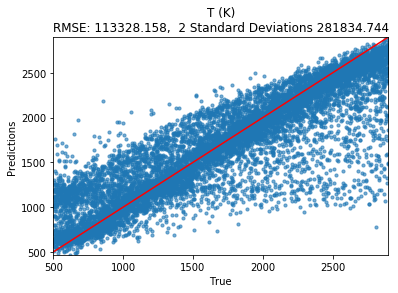

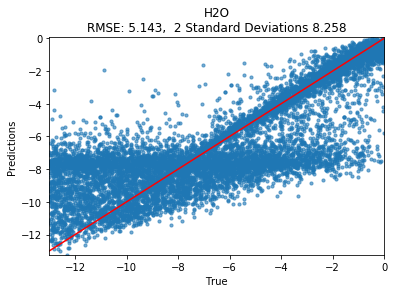

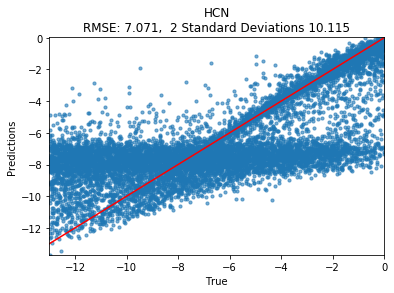

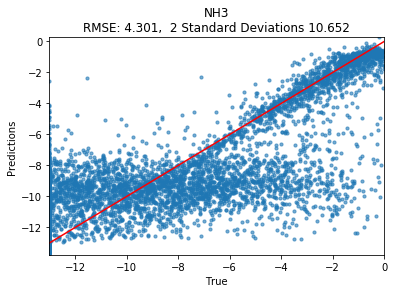

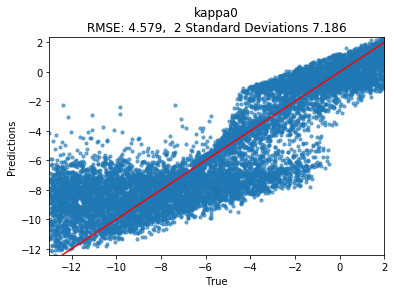

In [103]:
yyy = [-20,20] # This is just defining y = x
minx = np.min(y_data_val[:No_pred,:])
maxx = np.max(y_data_val[:No_pred,:])
miny = np.min(PRED.mean(1)[:,:])
maxy = np.max(PRED.mean(1)[:,:])
for mol in range(y_data_tr.shape[-1]):
    plt.title(names[mol])
    plt.ylabel('Predictions')
    plt.xlabel('True')
    minx = np.min(y_data_val_un[:No_pred,mol])
    maxx = np.max(y_data_val_un[:No_pred,mol])
    miny = np.min(PRED_un.mean(1)[:,mol])
    maxy = np.max(PRED_un.mean(1)[:,mol])
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])
    plt.scatter(y_data_val_un[:No_pred,mol],PRED_un.mean(1)[:,mol],s=10,alpha=0.6)
    yyy = [min(miny,minx),max(maxx,maxy)]
    plt.plot(yyy,yyy,'r')
    
#     print('For ',No_pred,' test planets:\n')
    # MSE: 
    MSE = np.mean((y_data_val_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
    sig = np.std((y_data_val_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
#     print(names[mol] + ' MSE: ',MSE, ' 2 Standard Deviations on MSE: ',2*sig)
    plt.title(names[mol] + '\nRMSE: %.3f,  2 Standard Deviations %.3f' % (MSE,sig))
    
    
    plt.savefig('./figures/valid/NN_validation'+names[mol]+'pred_vs_true.pdf')
    plt.show()

In [60]:
y_data.mean(0)

array([1699.36121053,   -6.51129457,   -6.48722569,  -10.27592468,
         -5.50126947])

In [57]:
y_data_val_un[:No_pred,mol].mean()  

-5.753109471334432

In [48]:
PRED_un.shape

(1000, 50, 5)

For  1000  test planets:

T (K) MSE:  0.23248251468196926  2 Standard Deviations on MSE:  1.23210732484612


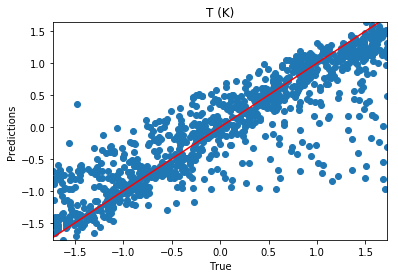

For  1000  test planets:

H2O MSE:  0.350586542182035  2 Standard Deviations on MSE:  1.2190034157732417


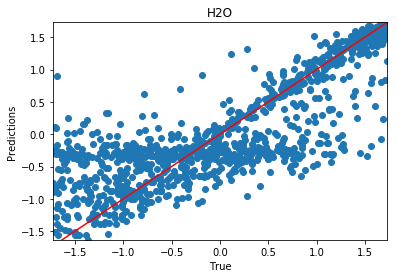

For  1000  test planets:

HCN MSE:  0.49605123589739386  2 Standard Deviations on MSE:  1.3671563729085303


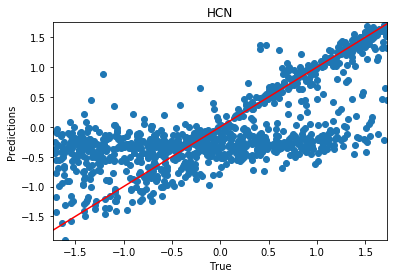

For  1000  test planets:

NH3 MSE:  0.2503189580894161  2 Standard Deviations on MSE:  1.214381710088528


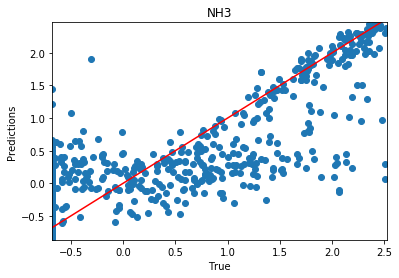

For  1000  test planets:

kappa0 MSE:  0.244395271996494  2 Standard Deviations on MSE:  0.7747753311232842


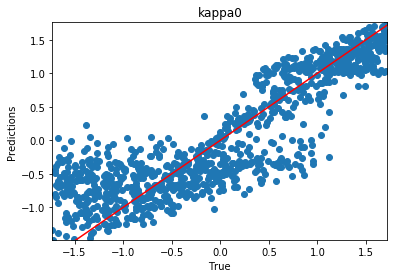

In [51]:
yyy = [-20,20] # This is just defining y = x
minx = np.min(y_data_val_un[:No_pred,:])
maxx = np.max(y_data_val_un[:No_pred,:])
miny = np.min(PRED_un.mean(1)[:,:])
maxy = np.max(PRED_un.mean(1)[:,:])
for mol in range(y_data_tr.shape[-1]):
    plt.title(names[mol])
    plt.ylabel('Predictions')
    plt.xlabel('True')
    minx = np.min(y_data_val_un[:No_pred,mol])
    maxx = np.max(y_data_val_un[:No_pred,mol])
    miny = np.min(PRED_un.mean(1)[:,mol])
    maxy = np.max(PRED_un.mean(1)[:,mol])
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])
    plt.scatter(y_data_val_un[:No_pred,mol],PRED_un.mean(1)[:,mol])
    plt.plot(yyy,yyy,'r')
    
    print('For ',No_pred,' test planets:\n')
    # MSE: 
    MSE = np.mean((y_data_val_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
    sig = np.std((y_data_val_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
    print(names[mol] + ' MSE: ',MSE, ' 2 Standard Deviations on MSE: ',2*sig)
    
    
#     plt.savefig('../figures/valid/Frank'+names[mol]+'pred_vs_true_CNN_1_network.pdf')
    plt.show()

## HELA PLOTTING FUNCTION

In [45]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn import metrics, neighbors
from sklearn.preprocessing import MinMaxScaler


def predicted_vs_real(y_real, y_pred, names, ranges):
    
    num_plots = y_pred.shape[1]
    num_plot_rows = int(np.sqrt(num_plots))
    num_plot_cols = (num_plots - 1) // num_plot_rows + 1
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(5*num_plot_cols, 5*num_plot_rows))
    
    for dim, (ax, name_i, range_i) in enumerate(zip(axes.ravel(), names, ranges)):
        
        current_real = y_real[:, dim]
        current_pred = y_pred[:, dim]
        
        r2 = metrics.r2_score(current_real, current_pred)
        label = "$R^2 = {:.3f}$".format(r2)
        ax.plot(current_real, current_pred, '.', label=label)
        
        ax.plot(range_i, range_i, '--', linewidth=3, color="C3")
        
        ax.axis("equal")
        ax.grid()
        ax.set_xlim(range_i)
        ax.set_ylim(range_i)
        ax.set_xlabel("Real {}".format(name_i), fontsize=18)
        ax.set_ylabel("Predicted {}".format(name_i), fontsize=18)
        ax.legend(loc="upper left", fontsize=14)
    
    fig.tight_layout()
    return fig


def feature_importances(forests, names, colors):
    
    num_plots = len(forests)
    num_plot_rows = (num_plots - 1) // 2 + 1
    num_plot_cols = 2
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(15, 3.5*num_plot_rows))
    
    for ax, forest_i, name_i, color_i in zip(axes.ravel(), forests, names, colors):
        ax.bar(np.arange(len(forest_i.feature_importances_)), forest_i.feature_importances_,
               label="Importance for {}".format(name_i),
               width=0.4, color=color_i)
        ax.set_xlabel("Feature index", fontsize=18)
        ax.legend(fontsize=16)
        ax.grid()
    
    fig.tight_layout()
    return fig


def posterior_matrix(estimations, y, names, ranges, colors, soft_colors=None):
    
    cmaps = [LinearSegmentedColormap.from_list("MyReds", [(1, 1, 1), c], N=256)
             for c in colors]
    
    ranges = np.array(ranges)
    
    if soft_colors is None:
        soft_colors = colors
    
    num_dims = estimations.shape[1]
    
    fig, axes = plt.subplots(nrows=num_dims, ncols=num_dims,
                             figsize=(2 * num_dims, 2 * num_dims))
    fig.subplots_adjust(left=0.07, right=1-0.05,
                        bottom=0.07, top=1-0.05,
                        hspace=0.05, wspace=0.05)
    
    for ax, dims in zip(axes.flat, product(range(num_dims), range(num_dims))):
        dims = list(dims[::-1])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_visible(False)
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_visible(True)
            if names is not None:
                ax.set_ylabel(names[dims[1]], fontsize=18)
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_visible(True)
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_visible(True)
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.xaxis.set_visible(True)
            if names is not None:
                ax.set_xlabel(names[dims[0]], fontsize=18)
        if ax.is_first_col() and ax.is_first_row():
            ax.yaxis.set_visible(False)
            ax.set_ylabel("")
        if ax.is_last_col() and ax.is_last_row():
            ax.yaxis.set_visible(False)
        
        if dims[0] < dims[1]:
            locations, kd_probs, *_ = _kernel_density_joint(estimations[:, dims], ranges[dims])
            ax.contour(locations[0], locations[1],
                       kd_probs,
                       colors=colors[dims[0]],
                       linewidths=0.5
                       # 'copper', # 'hot', 'magma' ('copper' with white background)
                      )
            histogram, grid_x, grid_y = _histogram(estimations[:, dims], ranges[dims])
            ax.pcolormesh(grid_x, grid_y, histogram, cmap=cmaps[dims[0]])
            
            expected = np.median(estimations[:, dims], axis=0)
            ax.plot([expected[0], expected[0]], [ranges[dims[1]][0], ranges[dims[1]][1]], '-', linewidth=1, color='#222222')
            ax.plot([ranges[dims[0]][0], ranges[dims[0]][1]], [expected[1], expected[1]], '-', linewidth=1, color='#222222')
            ax.plot(expected[0], expected[1], '.', color='#222222')
            ax.axis('normal')
            if y is not None:
                real = y[dims]
                ax.plot(real[0], real[1], '*', markersize=10, color='#FF0000')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        elif dims[0] > dims[1]:
            ax.plot(estimations[:, dims[0]], estimations[:, dims[1]], '.', color=soft_colors[dims[1]])
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        else:
            histogram, bins = _histogram(estimations[:, dims[:1]], ranges=ranges[dims[:1]])
            ax.bar(bins[:-1], histogram, color=soft_colors[dims[0]], width=bins[1]-bins[0])
            
            kd_probs = histogram
            expected = np.median(estimations[:, dims[0]])
            ax.plot([expected, expected], [0, 1.1 * kd_probs.max()], '-', linewidth=1, color='#222222')
            
            if y is not None:
                real = y[dims[0]]
                ax.plot([real, real], [0, kd_probs.max()], 'r-')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     0, 1.1 * kd_probs.max()])
    
    # fig.tight_layout(pad=0)
    return fig


def _min_max_scaler(ranges, feature_range=(0, 100)):
    res = MinMaxScaler()
    res.data_max_ = ranges[:, 1]
    res.data_min_ = ranges[:, 0]
    res.data_range_ = res.data_max_ - res.data_min_
    res.scale_ = (feature_range[1] - feature_range[0]) / (ranges[:, 1] - ranges[:, 0])
    res.min_ = -res.scale_ * res.data_min_
    res.n_samples_seen_ = 1
    res.feature_range = feature_range
    return res


def _kernel_density_joint(estimations, ranges, bandwidth=1/25):
    
    ndims = len(ranges)
    
    scaler = _min_max_scaler(ranges, feature_range=(0, 100))
    
    bandwidth = bandwidth * 100
    # step = 1.0
    
    kd = neighbors.KernelDensity(bandwidth=bandwidth).fit(scaler.transform(estimations))
    locations1d = np.arange(0, 100, 1)
    locations = np.reshape(np.meshgrid(*[locations1d] * ndims), (ndims, -1)).T
    kd_probs = np.exp(kd.score_samples(locations))
    
    shape = (ndims,) + (len(locations1d),) * ndims
    locations = scaler.inverse_transform(locations)
    locations = np.reshape(locations.T, shape)
    kd_probs = np.reshape(kd_probs, shape[1:])
    return locations, kd_probs, kd


def _histogram(estimations, ranges, bins=20):
    
    if len(ranges) == 1:
        histogram, edges = np.histogram(estimations[:, 0], bins=bins, range=ranges[0])
        return histogram, edges
    
    if len(ranges) == 2:
        histogram, xedges, yedges = np.histogram2d(estimations[:, 0], estimations[:, 1], bins=bins, range=ranges)
        grid_x, grid_y = np.meshgrid(xedges, yedges)
        return histogram.T, grid_x, grid_y, 

## Go back to original scale: (Un-normalise)

In [46]:
# un-normalise
PRED_un = PRED * y_data.std(0)[:num_features] +y_data.mean(0)[:num_features]
y_data_val_un = y_data_val * y_data.std(0)[:num_features] +y_data.mean(0)[:num_features]

## Plot posteriors

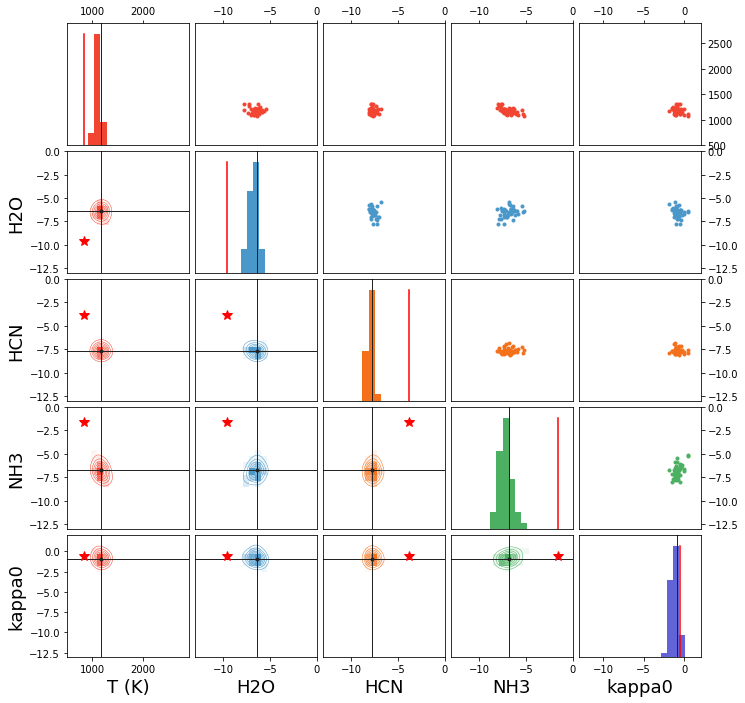

In [49]:
planet_id = 889; #101#50, 71, 11, 101, 50 51! 889! 0 is earth if in other cell -1 is selected
num_features = 12
#delta = 0.05
ranges=[[x, y] for x, y in zip(y_data_val_un.min(0), y_data_val_un.max(0))]
# FOR ZOOMED IN UNCOMMENT LINE BELOW
#ranges=[[x, y] for x, y in zip(PRED_un[planet_id,:,:num_features].min(0), PRED_un[planet_id,:,:num_features].max(0))]
# [[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, 1],[0, 1]]
# names =  ["H20", "CO2", "O2", "N2", "CH4", "C2H6", "O3", "N2O", "NH3", "SO2", "C25H28N6O7", "?"]
#names =  ["H20", "CO2", "O2", "N2", "CH4"]
#colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]#, "#F14532", "#4a98c9", "#f4701b", 
#           "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
# colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8", "#F14532", "#4a98c9", "#f4701b", 
#            "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
posterior_matrix(PRED_un[planet_id,:,:num_features], y_data_val_un[planet_id,:num_features], names, ranges, colors, soft_colors=None)
# plt.savefig('../figures/CNN1_planet_id'+str(planet_id + Ntr)+'.pdf')
plt.show()